In [ ]:
%%capture
!pip install tardis_dev
!pip install tardis_client
!pip install sortedcontainers

# Data Prep

In [ ]:
from tardis_dev import datasets
import datetime
import nest_asyncio
nest_asyncio.apply()
import gzip
import datetime
import pandas as pd
from collections import OrderedDict
import copy
import matplotlib.pyplot as plt
from __future__ import division
from collections import Counter
from sortedcontainers import SortedDict
import numpy as np
from tqdm import tqdm
from sklearn import preprocessing
import os
from scipy.linalg import block_diag
import scipy.stats as stats
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV, HalvingRandomSearchCV
from sklearn.base import BaseEstimator 

In [ ]:
EXCHANGE = "binance"
SYMBOL = "BTCUSDT"

FROM = "2021-12-01"
TO = "2021-12-02"

# FROM = "2021-08-01"
# TO = "2021-08-02"
# FROM = "2022-02-01"
# TO = "2022-02-02"

In [ ]:
datasets.download(
    exchange= EXCHANGE,
    data_types=[
        "incremental_book_L2",  
        "trades",
        "quotes",
        # "derivative_ticker",
        "book_snapshot_25"
    ],
    from_date=FROM,
    to_date=TO,
    symbols= [SYMBOL]
)

In [ ]:
fname_book = f'/content/datasets/{EXCHANGE}_incremental_book_L2_{FROM}_{SYMBOL}.csv.gz'
fname_trades = f'/content/datasets/{EXCHANGE}_trades_{FROM}_{SYMBOL}.csv.gz'

from_yr, from_mth, from_day = [int(i) for i in FROM.split("-")]
to_yr, to_mth, to_day = [int(i) for i in TO.split("-")]
from_ts = datetime.datetime(from_yr, from_mth, from_day, tzinfo=datetime.timezone.utc).timestamp()* 1000000
to_ts = datetime.datetime(to_yr, to_mth, to_day, tzinfo=datetime.timezone.utc).timestamp()* 1000000

In [ ]:
def addRow(df, timestamp, bids, asks):
  bid = bids.keys()[-1]
  ask = asks.keys()[0]
  bs  = bids[bid]
  as_ = asks[ask]
  mid = (bid + ask) / 2.0
  timestamp_dt = pd.to_datetime(timestamp, unit='us')
  row = [timestamp_dt, bid, ask, bs, as_ ]
  df.loc[len(df)] = row


In [ ]:
"""
Read tick-by-tick data for binance's BTC-USDT pair and store it in an sorted dict (Can consider RB Tree). 
"""
interval = 1
bids = SortedDict()
asks = SortedDict()
cols = ['timestamp_dt', 'bid', 'ask', 'bs', 'as']
df = pd.DataFrame(columns=cols)
line_counter = 0

if(os.path.exists(f"/content/{EXCHANGE}_{SYMBOL}_{FROM}.csv")):
  df = pd.read_csv(f"/content/{EXCHANGE}_{SYMBOL}_{FROM}.csv", index_col=0)
  df['timestamp_dt'] = pd.to_datetime(df['timestamp_dt'])
  
else:
   
  with gzip.open(fname_book) as f:
    line = f.readline()
    
    prev_snapshot = False
    processing_snapshot = False
    prev_timestamp = None
    bucket_timestamp = from_ts + (interval * 10**6)
    d = 0
    while line:
      line = f.readline()
      line_counter += 1
      if(line_counter % 1000000 == 0): print(f"Line : {line_counter}")
      if not line: break
      exchange, symbol, timestamp, local_timestamp, is_snapshot, side, price, amount = line.decode('utf-8').strip().split(',')
      price = float(price)
      amount = float(amount)
      local_timestamp = int(local_timestamp)
      
      
      if prev_timestamp != local_timestamp:
        while(local_timestamp > bucket_timestamp and (bids and asks)):
          addRow(df, bucket_timestamp, bids, asks)
          bucket_timestamp += (interval * 10**6)

      prev_timestamp = local_timestamp

      if(is_snapshot and not prev_snapshot):
        print("clearing")
        bids.clear()
        asks.clear()

      prev_snapshot = is_snapshot
 
      
      if (side == 'bid'):
        if(amount == 0 and price in bids):
          del bids[price]
        
        elif (amount != 0):
          bids[price] = amount
    
      elif (side == 'ask'):
        if(amount == 0 and price in asks):
          del asks[price]

        elif (amount != 0):
          asks[price] = amount 

        

  print("Saving ...")
  df.to_csv(f"/content/{EXCHANGE}_{SYMBOL}_{FROM}.csv")


# Calculate Microprice

In [ ]:
def prep_data_sym(T,n_imb,dt,n_spread):
    spread=T.ask-T.bid
    n = np.round(1/min(spread.loc[spread>0]))
    ticksize=np.round(min(spread.loc[spread>0])*n)/n
    # ticksize = 0.001
    T.spread=T.ask-T.bid
    # adds the spread and mid prices
    T['spread']=np.round((T['ask']-T['bid'])/ticksize)*ticksize
    T['mid']=(T['bid']+T['ask'])/2
    #filter out spreads >= n_spread
    T = T.loc[(T.spread <= n_spread*ticksize) & (T.spread>0)]
    T['imb']=T['bs']/(T['bs']+T['as'])
    #discretize imbalance into percentiles
    T['imb_bucket'] = pd.qcut(T['imb'], n_imb, labels=False)
    T['next_mid']=T['mid'].shift(-dt)
    #step ahead state variables
    T['next_spread']=T['spread'].shift(-dt)
    T['next_time']=T['timestamp_dt'].shift(-dt)
    T['next_imb_bucket']=T['imb_bucket'].shift(-dt)
    # step ahead change in price
    T['dM']=np.round((T['next_mid']-T['mid'])/ticksize*2)*ticksize/2
    T = T.loc[(T.dM <= ticksize*1.1) & (T.dM>=-ticksize*1.1)]

    # symetrize data
    T2 = T.copy(deep=True)
    T2['imb_bucket']=n_imb-1-T2['imb_bucket']
    T2['next_imb_bucket']=n_imb-1-T2['next_imb_bucket']
    T2['dM']=-T2['dM']
    T2['mid']=-T2['mid']
    T3=pd.concat([T,T2])
    # print(T3['state'])
    T3.index = pd.RangeIndex(len(T3.index)) 
    T3 = T3.dropna()
    return T, T3,ticksize

def getG6(G1,B,steps = 6):
  G2 = G1+np.dot(B,G1)
  G_steps = G2
  for i in range(3,steps+1):
    BB = np.dot(B,B)
    for j in range(3,i): #G3 -> G6
      BB = np.dot(BB,B)
    G_steps += np.dot(BB,G1)
  return G_steps


# def estimate(T, K):
#   # Transient
#   no_move=T[T['dM']==0]
#   no_move_counts = no_move.groupby(['spread', 'imb_bucket','next_imb_bucket'])["timestamp_dt"].count().unstack("next_imb_bucket", fill_value=0)
#   for i in range(n_spread):
#       Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
#       if (i==0): 
#         Q_counts = Qi             
#         continue
#       Q_counts=block_diag(Q_counts,Qi)
      

#   # Absorbing
#   move = T[(T['dM']!=0)]        
#   move_counts = move.groupby(['spread', 'imb_bucket','dM'])["timestamp_dt"].count().unstack("dM", fill_value=0).astype(float)
#   R_counts = np.resize(np.array(move_counts),(n_imb*n_spread,4))

#   # Get probabilities / matrix states
#   T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
#   T1 = preprocessing.normalize(T1, norm="l1")

#   Q=T1[:,0:(n_imb*n_spread)]
#   R1=T1[:,(n_imb*n_spread):]

#   move_counts_2 = move.groupby(['spread', 'imb_bucket','next_spread', 'next_imb_bucket'])["timestamp_dt"].count().unstack(['spread', 'imb_bucket'], fill_value=0).astype(float)
#   R2_counts=np.resize(np.array(move_counts_2),(n_imb*n_spread,n_imb*n_spread))
#   T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)
#   T2 = preprocessing.normalize(T2, norm="l1")

#   Q2=T2[:,0:(n_imb*n_spread)]
#   R2=T2[:,(n_imb*n_spread):]

#   # G1, B
#   G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
#   B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
#   return G1,B

def estimate(T, K):
  # Transient
  no_move=T[T['dM']==0]
  no_move_counts = no_move.groupby(['spread', 'imb_bucket','next_spread','next_imb_bucket'])["timestamp_dt"].count().unstack(fill_value=0)
  for i in range(n_spread):
      Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
      Q_counts = Qi if i==0  else block_diag(Q_counts,Qi)   
     

  # Absorbing
  move = T[(T['dM']!=0)]        
  move_counts = move.groupby(['spread', 'imb_bucket','dM'])["timestamp_dt"].count().unstack(fill_value=0).astype(float)
  R_counts = np.resize(np.array(move_counts),(n_imb*n_spread,len(K)))

  # Get probabilities / matrix states
  T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
  T1 = preprocessing.normalize(T1, norm="l1")

  Q=T1[:,0:(n_imb*n_spread)]
  R1=T1[:,(n_imb*n_spread):]

  move_counts_2 = move.groupby(['spread', 'imb_bucket','next_spread', 'next_imb_bucket'])["timestamp_dt"].count().unstack(fill_value=0).astype(float)
  R2_counts=np.resize(np.array(move_counts_2),(n_imb*n_spread,n_imb*n_spread))
  T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)
  T2 = preprocessing.normalize(T2, norm="l1")

  Q2=T2[:,0:(n_imb*n_spread)]
  R2=T2[:,(n_imb*n_spread):]

  # G1, B
  G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
  B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
  return G1,B

def getG6(G1,B,steps = 6):
  G2 = G1+np.dot(B,G1)
  G_steps = G2
  for i in range(3,steps+1):
    BB = np.dot(B,B)
    for j in range(3,i): #G3 -> G6
      BB = np.dot(BB,B)
    G_steps += np.dot(BB,G1)
  return G_steps



In [ ]:
spread=df.ask-df.bid
spread.loc[spread <= 0.02]

0        0.01
1        0.01
4        0.01
5        0.01
6        0.01
         ... 
86394    0.01
86395    0.01
86396    0.01
86397    0.01
86398    0.01
Length: 80162, dtype: float64

In [ ]:
# KEK

In [ ]:
n_imb = 10
dt = 1
n_spread = 2

T_, T, ts = prep_data_sym(df, n_imb, dt, n_spread)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-package

In [ ]:
T_ 

,timestamp_dt,bid,ask,bs,as,spread,mid,imb,imb_bucket,next_mid,next_spread,next_time,next_imb_bucket,dM
0,2021-12-01 00:00:01,56958.38,56958.39,0.08428,1.15375,0.01,56958.385,0.068076,1,56958.385,0.01,2021-12-01 00:00:02,1.0,0.00
4,2021-12-01 00:00:05,56951.60,56951.61,0.59824,0.12631,0.01,56951.605,0.825671,7,56951.605,0.01,2021-12-01 00:00:06,8.0,0.00
7,2021-12-01 00:00:08,56951.60,56951.61,0.33894,0.41144,0.01,56951.605,0.451691,4,56951.595,0.01,2021-12-01 00:00:09,5.0,-0.01
8,2021-12-01 00:00:09,56951.59,56951.60,0.56059,0.32671,0.01,56951.595,0.631793,5,56951.595,0.01,2021-12-01 00:00:10,7.0,0.00
27,2021-12-01 00:00:28,56969.54,56969.55,0.07523,0.49500,0.01,56969.545,0.131929,2,56969.545,0.01,2021-12-01 00:00:29,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86388,2021-12-01 23:59:49,57197.72,57197.73,0.34051,0.48523,0.01,57197.725,0.412370,4,57197.725,0.01,2021-12-01 23:59:50,6.0,0.00
86389,2021-12-01 23:59:50,57197.72,57197.73,0.33602,0.15023,0.01,57197.725,0.691044,6,57197.725,0.01,2021-12-01 23:59:51,6.0,0.00
86392,2021-12-01 23:59:53,57195.00,57195.01,0.00101,0.73016,0.01,57195.005,0.001381,0,57195.005,0.01,2021-12-01 23:59:54,0.0,0.00
86396,2021-12-01 23:59:57,57184.07,57184.08,0.03158,0.68799,0.01,57184.075,0.043887,1,57184.075,0.01,2021-12-01 23:59:58,1.0,0.00


In [ ]:
K = np.array([-ts, -ts*0.5, ts*0.5, ts])
G1, B = estimate(T,K)
print(G1,"\n\n", B)
G6= getG6(G1,B)  

[-0.0011133  -0.00094408 -0.00060406 -0.00031967 -0.00016203  0.00016203
  0.00031967  0.00060406  0.00094408  0.0011133   0.         -0.0025
 -0.005      -0.005       0.005      -0.005       0.005       0.005
  0.0025      0.        ] 

 [[1.30987047e-01 1.30260649e-01 9.17221386e-02 8.49518133e-02
  7.97113874e-02 8.19850021e-02 8.08368314e-02 8.82336751e-02
  1.14561167e-01 1.08101937e-01 1.06406630e-03 1.44589529e-03
  7.09288855e-04 1.94351556e-04 9.51457908e-04 4.92120523e-04
  2.21055392e-04 1.12015674e-03 9.30435569e-04 1.51952355e-03]
 [1.24844519e-01 1.34305854e-01 9.25083989e-02 8.66646534e-02
  8.07312280e-02 8.05574406e-02 8.43866284e-02 8.84412641e-02
  1.13342797e-01 1.06277283e-01 1.11145126e-03 1.51685503e-03
  7.47836436e-04 2.01658870e-04 6.29376615e-04 5.10249919e-04
  2.41009001e-04 7.95604669e-04 9.66160070e-04 1.21973256e-03]
 [1.21820720e-01 1.27847908e-01 9.29961107e-02 8.65259316e-02
  8.29839330e-02 8.13686094e-02 8.37290895e-02 8.73091301e-02
  1.16163686e-0

In [ ]:
df_g6 = pd.DataFrame(np.reshape(G6,(n_imb, n_spread )))
df_g6.index = np.linspace(0, n_imb-1, num=n_imb).astype(int)
df_g6 = df_g6.rename(columns=dict(zip(list(df_g6.columns), sorted(T['spread'].unique()))))

In [ ]:
mp_adjustments = []
T = T_ 
for spread,imb in zip(T["spread"], T["imb_bucket"]):
  mp_adjustments.append(df_g6.loc[imb, spread])

T['microprice'] = np.array(mp_adjustments) + T["mid"]


shifts = 5

for i in range(1,shifts+1):
  T[f'microprice_{i}'] = T['microprice'].shift(i)
 
 
  

In [ ]:
T = T.dropna()

In [ ]:
T

,timestamp_dt,bid,ask,bs,as,spread,mid,imb,imb_bucket,next_mid,next_spread,next_time,next_imb_bucket,dM,microprice,microprice_1,microprice_2,microprice_3,microprice_4,microprice_5
28,2021-12-01 00:00:29,56969.54,56969.55,0.06492,0.48045,0.01,56969.545,0.119038,1,56969.545,0.01,2021-12-01 00:00:30,9.0,0.00,56969.544352,56969.544816,56951.593312,56951.605974,56951.611842,56958.384352
29,2021-12-01 00:00:30,56969.54,56969.55,0.35131,0.00200,0.01,56969.545,0.994339,9,56969.545,0.01,2021-12-01 00:00:31,9.0,0.00,56969.547399,56969.544352,56969.544816,56951.593312,56951.605974,56951.611842
44,2021-12-01 00:00:45,56876.00,56876.01,0.01468,0.16183,0.01,56876.005,0.083168,1,56876.005,0.01,2021-12-01 00:00:46,1.0,0.00,56876.004352,56969.547399,56969.544352,56969.544816,56951.593312,56951.605974
83,2021-12-01 00:01:24,56860.68,56860.69,0.06600,0.04398,0.01,56860.685,0.600109,5,56860.685,0.01,2021-12-01 00:01:25,8.0,0.00,56860.683312,56876.004352,56969.547399,56969.544352,56969.544816,56951.593312
89,2021-12-01 00:01:30,56838.43,56838.44,0.00176,0.16039,0.01,56838.435,0.010854,0,56838.435,0.01,2021-12-01 00:01:31,6.0,0.00,56838.433830,56860.683312,56876.004352,56969.547399,56969.544352,56969.544816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86388,2021-12-01 23:59:49,57197.72,57197.73,0.34051,0.48523,0.01,57197.725,0.412370,4,57197.725,0.01,2021-12-01 23:59:50,6.0,0.00,57197.725974,57196.873312,57195.033312,57197.893830,57197.893830,57191.021842
86389,2021-12-01 23:59:50,57197.72,57197.73,0.33602,0.15023,0.01,57197.725,0.691044,6,57197.725,0.01,2021-12-01 23:59:51,6.0,0.00,57197.717221,57197.725974,57196.873312,57195.033312,57197.893830,57197.893830
86392,2021-12-01 23:59:53,57195.00,57195.01,0.00101,0.73016,0.01,57195.005,0.001381,0,57195.005,0.01,2021-12-01 23:59:54,0.0,0.00,57195.003830,57197.717221,57197.725974,57196.873312,57195.033312,57197.893830
86396,2021-12-01 23:59:57,57184.07,57184.08,0.03158,0.68799,0.01,57184.075,0.043887,1,57184.075,0.01,2021-12-01 23:59:58,1.0,0.00,57184.074352,57195.003830,57197.717221,57197.725974,57196.873312,57195.033312


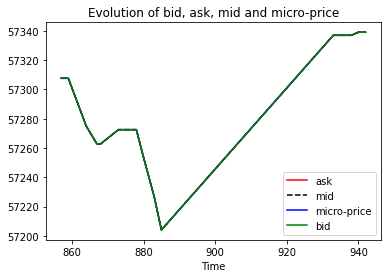

In [ ]:
df_subset = T[100:120]

plt.plot(df_subset["ask"], "r")
plt.plot(df_subset["mid"], "k--")
plt.plot(df_subset["microprice"], "b")
plt.plot(df_subset["bid"], "g")
plt.title("Evolution of bid, ask, mid and micro-price")
plt.xlabel("Time")
plt.legend(["ask", "mid", "micro-price", "bid"], loc="lower right")

plt.show()

In [ ]:
T

,timestamp_dt,bid,ask,bs,as,spread,mid,imb,imb_bucket,next_mid,next_spread,next_time,next_imb_bucket,dM,microprice,microprice_1,microprice_2,microprice_3,microprice_4,microprice_5
28,2021-12-01 00:00:29,56969.54,56969.55,0.06492,0.48045,0.01,56969.545,0.119038,1,56969.545,0.01,2021-12-01 00:00:30,9.0,0.00,56969.544352,56969.544816,56951.593312,56951.605974,56951.611842,56958.384352
29,2021-12-01 00:00:30,56969.54,56969.55,0.35131,0.00200,0.01,56969.545,0.994339,9,56969.545,0.01,2021-12-01 00:00:31,9.0,0.00,56969.547399,56969.544352,56969.544816,56951.593312,56951.605974,56951.611842
44,2021-12-01 00:00:45,56876.00,56876.01,0.01468,0.16183,0.01,56876.005,0.083168,1,56876.005,0.01,2021-12-01 00:00:46,1.0,0.00,56876.004352,56969.547399,56969.544352,56969.544816,56951.593312,56951.605974
83,2021-12-01 00:01:24,56860.68,56860.69,0.06600,0.04398,0.01,56860.685,0.600109,5,56860.685,0.01,2021-12-01 00:01:25,8.0,0.00,56860.683312,56876.004352,56969.547399,56969.544352,56969.544816,56951.593312
89,2021-12-01 00:01:30,56838.43,56838.44,0.00176,0.16039,0.01,56838.435,0.010854,0,56838.435,0.01,2021-12-01 00:01:31,6.0,0.00,56838.433830,56860.683312,56876.004352,56969.547399,56969.544352,56969.544816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86388,2021-12-01 23:59:49,57197.72,57197.73,0.34051,0.48523,0.01,57197.725,0.412370,4,57197.725,0.01,2021-12-01 23:59:50,6.0,0.00,57197.725974,57196.873312,57195.033312,57197.893830,57197.893830,57191.021842
86389,2021-12-01 23:59:50,57197.72,57197.73,0.33602,0.15023,0.01,57197.725,0.691044,6,57197.725,0.01,2021-12-01 23:59:51,6.0,0.00,57197.717221,57197.725974,57196.873312,57195.033312,57197.893830,57197.893830
86392,2021-12-01 23:59:53,57195.00,57195.01,0.00101,0.73016,0.01,57195.005,0.001381,0,57195.005,0.01,2021-12-01 23:59:54,0.0,0.00,57195.003830,57197.717221,57197.725974,57196.873312,57195.033312,57197.893830
86396,2021-12-01 23:59:57,57184.07,57184.08,0.03158,0.68799,0.01,57184.075,0.043887,1,57184.075,0.01,2021-12-01 23:59:58,1.0,0.00,57184.074352,57195.003830,57197.717221,57197.725974,57196.873312,57195.033312


In [ ]:
T['timestamp_dt'] = pd.to_datetime(T['timestamp_dt'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_trades = pd.read_csv(fname_trades)
df_trades.index = pd.to_datetime(df_trades['local_timestamp'], unit='us')

In [ ]:
ohlcv = df_trades.resample(f'{interval}s', closed='right', label='right').agg({'price': 'ohlc', 'amount': 'sum'})
ohlcv.columns = ['open', 'high', 'low', 'close', 'volume']
ohlcv

,open,high,low,close,volume
local_timestamp,,,,,
2021-12-01 00:00:01,56950.56,56958.93,56947.89,56958.93,2.16854
2021-12-01 00:00:02,56951.75,56961.24,56951.75,56958.39,0.60259
2021-12-01 00:00:03,56958.39,56958.39,56948.32,56948.33,0.28337
2021-12-01 00:00:04,56948.33,56958.39,56948.33,56951.60,0.88236
2021-12-01 00:00:05,56951.61,56951.61,56951.60,56951.60,0.08114
...,...,...,...,...,...
2021-12-01 23:59:56,57191.01,57191.02,57186.90,57186.90,1.70056
2021-12-01 23:59:57,57186.91,57186.91,57184.07,57184.07,0.07884
2021-12-01 23:59:58,57184.08,57184.08,57184.07,57184.08,0.27041


In [ ]:
df_imb_trades = ohlcv.merge(T, left_index=True, right_on="timestamp_dt", how='outer', sort=True)
df_imb_trades = df_imb_trades.dropna()

In [ ]:
df_imb_trades = df_imb_trades.set_index('timestamp_dt', drop = False)

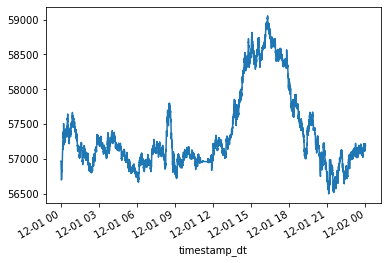

In [ ]:
df_imb_trades['open'].plot()  

In [ ]:
#  df_imb_trades = df_imb_trades.apply(lambda x: x.fillna(df_imb_trades['open'])) 
#  df_imb_trades =  df_imb_trades.dropna()

# Backtesting 

In [ ]:
def getTrainValSplit(df, train_split):
  total_length = len(df)
  split = int(train_split*total_length)
  df_train = df[:split]
  df_val = df[split: ]
  return df_train, df_val

def is_bid_crossed(bid, low, ticksize = 0.01):
  return int(round(bid / ticksize)) > int(round(low / ticksize))

def is_ask_crossed(ask, high, ticksize = 0.01):
  return int(round(ask / ticksize)) < int(round(high / ticksize))

# df_imb_trades.mid = abs(df_imb_trades.mid)
df_train, df_val = getTrainValSplit(df_imb_trades, 0.7)


In [ ]:
for ind,i in enumerate(df_train.columns):
  print(i,"--" ,ind)

open -- 0
high -- 1
low -- 2
close -- 3
volume -- 4
timestamp_dt -- 5
bid -- 6
ask -- 7
bs -- 8
as -- 9
spread -- 10
mid -- 11
imb -- 12
imb_bucket -- 13
next_mid -- 14
next_spread -- 15
next_time -- 16
next_imb_bucket -- 17
dM -- 18
microprice -- 19
microprice_1 -- 20
microprice_2 -- 21
microprice_3 -- 22
microprice_4 -- 23
microprice_5 -- 24


In [ ]:
df_train

,open,high,low,close,volume,timestamp_dt,bid,ask,bs,as,...,next_spread,next_time,next_imb_bucket,dM,microprice,microprice_1,microprice_2,microprice_3,microprice_4,microprice_5
timestamp_dt,,,,,,,,,,,,,,,,,,,,,
2021-12-01 00:00:29,56969.54,56969.55,56969.54,56969.55,0.05592,2021-12-01 00:00:29,56969.54,56969.55,0.06492,0.48045,...,0.01,2021-12-01 00:00:30,9.0,0.00,56969.544352,56969.544816,56951.593312,56951.605974,56951.611842,56958.384352
2021-12-01 00:00:30,56969.55,56969.55,56969.50,56969.54,0.12670,2021-12-01 00:00:30,56969.54,56969.55,0.35131,0.00200,...,0.01,2021-12-01 00:00:31,9.0,0.00,56969.547399,56969.544352,56969.544816,56951.593312,56951.605974,56951.611842
2021-12-01 00:00:45,56881.87,56896.92,56876.01,56876.01,0.68744,2021-12-01 00:00:45,56876.00,56876.01,0.01468,0.16183,...,0.01,2021-12-01 00:00:46,1.0,0.00,56876.004352,56969.547399,56969.544352,56969.544816,56951.593312,56951.605974
2021-12-01 00:01:24,56848.68,56860.69,56848.68,56860.69,0.11884,2021-12-01 00:01:24,56860.68,56860.69,0.06600,0.04398,...,0.01,2021-12-01 00:01:25,8.0,0.00,56860.683312,56876.004352,56969.547399,56969.544352,56969.544816,56951.593312
2021-12-01 00:01:30,56854.96,56858.62,56834.85,56838.44,3.46045,2021-12-01 00:01:30,56838.43,56838.44,0.00176,0.16039,...,0.01,2021-12-01 00:01:31,6.0,0.00,56838.433830,56860.683312,56876.004352,56969.547399,56969.544352,56969.544816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01 16:32:50,58687.15,58689.00,58687.14,58688.99,0.26550,2021-12-01 16:32:50,58688.99,58689.00,0.37328,2.45530,...,0.01,2021-12-01 16:32:51,2.0,0.00,58688.994816,58687.495974,58687.493830,58700.009637,58700.005974,58700.005316
2021-12-01 16:32:51,58689.00,58689.00,58688.99,58689.00,0.08699,2021-12-01 16:32:51,58688.99,58689.00,0.55246,2.29355,...,0.01,2021-12-01 16:32:52,1.0,0.00,58688.994816,58688.994816,58687.495974,58687.493830,58700.009637,58700.005974
2021-12-01 16:32:55,58686.73,58689.00,58686.73,58689.00,0.35898,2021-12-01 16:32:55,58688.99,58689.00,1.21471,1.69912,...,0.01,2021-12-01 16:32:56,2.0,0.00,58688.995974,58688.994816,58688.994816,58687.495974,58687.493830,58700.009637


In [ ]:
df_val

,open,high,low,close,volume,timestamp_dt,bid,ask,bs,as,...,next_spread,next_time,next_imb_bucket,dM,microprice,microprice_1,microprice_2,microprice_3,microprice_4,microprice_5
timestamp_dt,,,,,,,,,,,,,,,,,,,,,
2021-12-01 16:32:59,58687.01,58687.01,58686.99,58687.00,0.20010,2021-12-01 16:32:59,58686.99,58687.00,0.13236,0.60901,...,0.01,2021-12-01 16:33:00,6.0,0.00,58686.994816,58686.997221,58687.004816,58688.995974,58688.994816,58688.994816
2021-12-01 16:33:02,58686.74,58689.00,58686.74,58688.99,1.59155,2021-12-01 16:33:02,58688.99,58689.00,0.58764,1.38769,...,0.01,2021-12-01 16:33:03,3.0,0.00,58688.995316,58686.994816,58686.997221,58687.004816,58688.995974,58688.994816
2021-12-01 16:33:04,58688.99,58692.85,58688.99,58692.85,1.35080,2021-12-01 16:33:04,58690.91,58690.92,0.64120,0.14281,...,0.01,2021-12-01 16:33:05,7.0,0.00,58690.921842,58688.995316,58686.994816,58686.997221,58687.004816,58688.995974
2021-12-01 16:33:07,58695.33,58698.99,58695.33,58698.99,0.12277,2021-12-01 16:33:07,58698.99,58699.00,0.33431,1.29459,...,0.01,2021-12-01 16:33:08,3.0,0.00,58698.994816,58690.921842,58688.995316,58686.994816,58686.997221,58687.004816
2021-12-01 16:33:10,58693.56,58693.56,58690.00,58690.01,0.21025,2021-12-01 16:33:10,58690.00,58690.01,0.34939,0.32328,...,0.01,2021-12-01 16:33:11,3.0,0.00,58690.003312,58698.994816,58690.921842,58688.995316,58686.994816,58686.997221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-01 23:59:49,57196.87,57197.72,57196.87,57197.72,0.00964,2021-12-01 23:59:49,57197.72,57197.73,0.34051,0.48523,...,0.01,2021-12-01 23:59:50,6.0,0.00,57197.725974,57196.873312,57195.033312,57197.893830,57197.893830,57191.021842
2021-12-01 23:59:50,57197.72,57197.72,57197.72,57197.72,0.00449,2021-12-01 23:59:50,57197.72,57197.73,0.33602,0.15023,...,0.01,2021-12-01 23:59:51,6.0,0.00,57197.717221,57197.725974,57196.873312,57195.033312,57197.893830,57197.893830
2021-12-01 23:59:53,57195.95,57195.95,57195.01,57195.01,0.58079,2021-12-01 23:59:53,57195.00,57195.01,0.00101,0.73016,...,0.01,2021-12-01 23:59:54,0.0,0.00,57195.003830,57197.717221,57197.725974,57196.873312,57195.033312,57197.893830


In [ ]:
class Backtest:
    def __init__(self, base_qty = 1, quote_equity = 50000, order_qty_base = 0.05, fee_percentage=None, max_position=None, A=None, B=None, half_spread=None, order_mul = None, mp_shift = None, tick_size = 0.01):
        self.order_qty_base = order_qty_base
        self.base_qty = base_qty
        self.quote_equity = quote_equity
        self.fee_percentage = fee_percentage
        self.max_position = max_position
        self.A = A
        self.B = B
        self.half_spread = half_spread
        self.order_mul = order_mul
        self.tick_size = tick_size
        self.mp_shift = mp_shift
    
        
    def set_params(self, A, B, half_spread, order_mul, mp_shift):
        self.A = A
        self.B = B
        self.half_spread = half_spread
        self.order_mul = order_mul
        self.mp_shift = mp_shift
        return self
        
    def get_params(self, deep=True):
        return { 
            'mp_shift': self.mp_shift,
            'order_mul': self.order_mul,
            'fee_percentage': self.fee_percentage,
            'max_position': self.max_position,
            'A': self.A,
            'B': self.B,
            'half_spread': self.half_spread 
            }
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        fee = self.fee_percentage/100.0
        quote_equity_history = []
        equity_history = []
        base_qty_history = []
        bid_order_qty_btc = self.order_qty_base
        ask_order_qty_btc = self.order_qty_base
        new_bid = None
        new_ask = None

        high = 1
        open = 0
        low = 2
        close = 3
        volume = 4
        best_bid = 6
        best_ask = 7
        mid = 11
        microprice = 19
        quote_base_ratio, prev_mid, prev_close, prev_mp = 0, 0, 0, 0

         
        for ind, row in enumerate(X):
          if(len(base_qty_history)):
            print(f"{new_bid}--|{row[close]}|--{new_ask}")
      
          ask_order_qty_btc = self.order_qty_base  
          bid_order_qty_btc = self.order_qty_base  

          if ((new_bid and not new_ask)):
            bid_order_qty_btc = self.order_qty_base * self.order_mul

          if ((not new_bid and new_ask)):
            ask_order_qty_btc = self.order_qty_base * self.order_mul

          
          # Check if bids & asks are filled
          if new_bid and is_bid_crossed(new_bid, row[low], self.tick_size):
            print(f"+++ Buying {bid_order_qty_btc} BTC @{new_bid}")
            self.base_qty += bid_order_qty_btc
            self.quote_equity -= (bid_order_qty_btc * new_bid) * (fee+1)
             
          if new_ask and is_ask_crossed(new_ask, row[high], self.tick_size):
            print(f"--- Selling {ask_order_qty_btc} BTC @{new_ask}")
            self.base_qty -= ask_order_qty_btc
            self.quote_equity += (ask_order_qty_btc * new_ask ) * (1-fee)
             

          # Store and Update variables
          base_equity = row[close] * self.base_qty
          equity_history.append(self.quote_equity + base_equity)
          quote_equity_history.append(self.quote_equity)
          base_qty_history.append(self.base_qty)
          
          """
          Calculation for next best bid and ask orders
          - BuyPrice = Mid-Market + A x Forecast – B x MCR – Current half-spread
          - SellPrice = Mid-Market + A x Forecast – B x MCR + Current half-spread
          - Clamp bids and asks so we don't be takers
          """
          mcr = base_equity / self.max_position
                
          new_bid = prev_close + self.A * row[self.mp_shift] - self.B * mcr - self.half_spread 
          new_ask = prev_close + self.A * row[self.mp_shift] - self.B * mcr + self.half_spread 

          if (self.quote_equity <= 0 or equity_history[-1] > self.max_position*2 or new_bid >= row[mid]):
            new_bid = None
        
          if (equity_history[-1] < -1*self.max_position or ask_order_qty_btc > self.base_qty or new_ask <= row[mid]):
            new_ask = None

        # Store prev
          prev_mid = row[mid]
          prev_close = row[close]
          prev_mp = row[microprice]
            
        return equity_history, quote_equity_history, base_qty_history
      
    
    def score(self, X):
        equity, _, __ = self.predict(X)
        returns = (pd.Series(equity).diff() / self.max_position).fillna(0)
        score = np.divide(returns.mean(), returns.std())
        print("Score:", score)
        return score

In [ ]:
param_distribution = { 'A': stats.uniform(0,0.00001), 'B': stats.uniform(0, 1), 'half_spread': stats.uniform(0, 0.001), 'order_mul' : stats.uniform(0,0.5), 'mp_shift':np.arange(19,25) }
base_qty = 1
quote_equity = 50000
order_qty_base = 0.05
max_pos = 250000
fee_pct = 0.1
search = RandomizedSearchCV(Backtest(base_qty,quote_equity,order_qty_base, fee_pct, max_pos, tick_size = ts),
                            cv=[(np.arange(len(df_train)), np.arange(len(df_train)))],
                            param_distributions=param_distribution,
                            verbose=1,
                            n_iter=100,
                            n_jobs=8)

search.fit(df_train.values)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


RandomizedSearchCV(cv=[(array([    0,     1,     2, ..., 22981, 22982, 22983]),
                        array([    0,     1,     2, ..., 22981, 22982, 22983]))],
                   estimator=<__main__.Backtest object at 0x7f72323dfe10>,
                   n_iter=100, n_jobs=8,
                   param_distributions={'A': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7232b8bed0>,
                                        'B': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f7235882f50>,
                                        'half_spread': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f72342b4c10>,
                                        'mp_shift': array([19, 20, 21, 22, 23, 24]),
                                        'order_mul': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f723218cf90>},
                   verbose=1)

In [ ]:
best = search.best_params_
best

{'A': 4.001716944627121e-07,
 'B': 0.7819659362143597,
 'half_spread': 0.00025604324095881894,
 'mp_shift': 20,
 'order_mul': 0.00817497942988199}

In [ ]:
df_ = df_train 
# df_ = df_val
equity_history, quote_equity_history, base_qty = search.best_estimator_.predict(df_.values)
quote_equity = pd.Series(quote_equity_history, index=df_.index)
equity = pd.Series(equity_history, index=df_.index)
base_qty = pd.Series(base_qty, index=df_.index)

Streaming output truncated to the last 5000 lines.
None--|57307.66|--None
None--|57285.99|--None
None--|57281.03|--57307.34666123374
None--|57290.75|--57285.676681693105
--- Selling 0.00040874897149409953 BTC @57285.676681693105
None--|57290.75|--None
None--|57290.74|--None
None--|57299.11|--None
None--|57299.11|--None
None--|57290.75|--None
None--|57290.75|--57298.79670309495
None--|57290.74|--None
None--|57290.74|--None
None--|57284.06|--None
None--|57262.46|--57290.42673903704
None--|57259.57|--57283.74686322211
None--|57261.55|--57262.14687155234
None--|57271.0|--None
None--|57275.62|--None
None--|57275.61|--None
None--|57268.56|--None
None--|57266.29|--57275.29682401815
None--|57266.29|--57268.246834524936
None--|57266.29|--None
None--|57261.55|--None
None--|57261.56|--57265.976861459334
None--|57259.79|--None
None--|57259.79|--57261.24686989942
None--|57259.79|--None
None--|57257.43|--None
None--|57257.44|--57259.47688305576
None--|57257.43|--None
None--|57257.43|--None
None--|57

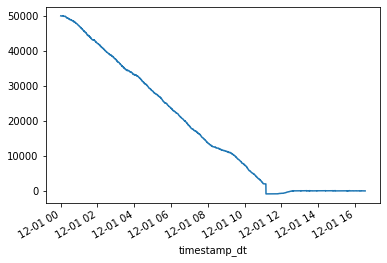

In [ ]:
quote_equity.plot()

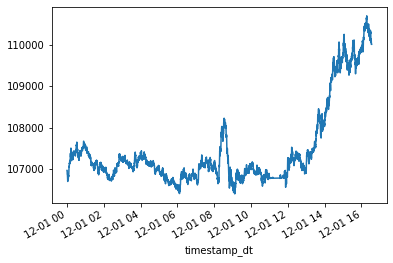

In [ ]:
equity.plot()

In [ ]:
ls = list(equity)
profit = ls[-1] - ls[0]
print(f"Profit : {np.round(profit,2)}")
 

Profit : 3040.21


Max-Profit : 3728.22


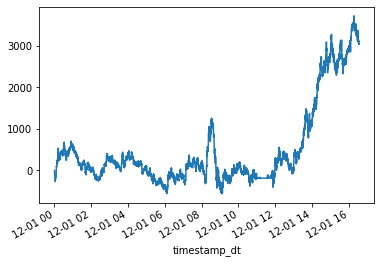

In [ ]:
ls_profit = [i-ls[0] for i in ls]
pd.Series(ls_profit, index=df_.index).plot()
print(f"Max-Profit : {np.round(max(ls_profit),2)}")

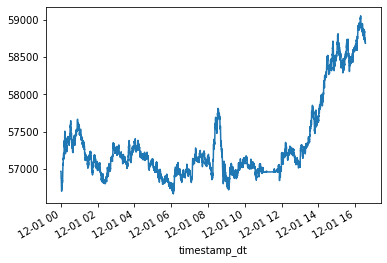

In [ ]:
df_['close'].plot()

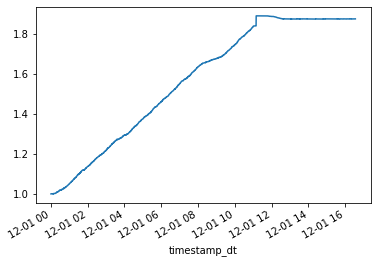

In [ ]:
base_qty.plot()

In [ ]:
# {'A': 0.027197162087496562,
#  'B': 0.22211452816771438,
#  'half_spread': 1.7041630370914442e-05,
#  'mp_shift': 21,
#  'order_mul': 0.43149098549075326}


# {'A': 0.1332899630641935,
#  'B': 0.8518493602245304,
#  'half_spread': 0.0004612127373932643,
#  'mp_shift': 24,
#  'order_mul': 0.5944614037177571}

# {'A': 0.01975556961337377,
#  'B': 0.3011611447764876,
#  'half_spread': 0.0009983730322202977,
#  'mp_shift': 24,
#  'order_mul': 0.048688064002137654}

In [ ]:
# 2021-12
{'A': 0.10824001577139464,
 'B': 0.7103525177855982,
 'half_spread': 0.0007000883651398231,
 'mp_shift': 22,
 'order_mul': 0.004108577246146827}

{'A': 0.5107940717085637,
'B': 0.26269957232700814,
'half_spread': 0.0008458513868883955,
'mp_shift': 19,
'order_mul': 0.0072441159507840025}

{'A': 4.001716944627121e-07,
 'B': 0.7819659362143597,
 'half_spread': 0.00025604324095881894,
 'mp_shift': 20,
 'order_mul': 0.00817497942988199}


{'A': 0.5107940717085637,
 'B': 0.26269957232700814,
 'half_spread': 0.0008458513868883955,
 'mp_shift': 19,
 'order_mul': 0.0072441159507840025}

In [ ]:
# params = {'A': 0.1332899630641935,
#  'B': 0.8518493602245304,
#  'half_spread': 0.0004612127373932643,
#  'mp_shift': 24,
#  'order_mul': 0.5944614037177571}

params = {'A': 0.01975556961337377,
 'B': 0.3011611447764876,
 'half_spread': 0.0009983730322202977,
 'mp_shift': 24,
 'order_mul': 0.048688064002137654}


base_qty = 1
quote_equity = 40000
order_qty_base = 0.05
max_pos = 250000
fee_pct = 0.1

In [ ]:
df_ = df_train
bt = Backtest(
    base_qty,quote_equity,order_qty_base, fee_pct, max_pos, 
    tick_size = ts,
    A=params['A'],
    B=params['B'],
    half_spread=params['half_spread'],
    mp_shift=params['mp_shift'],
    order_mul=params['order_mul']

)
equity_history, quote_equity_history, base_qty = bt.predict(df_.values)
quote_equity = pd.Series(quote_equity_history, index=df_.index)
equity = pd.Series(equity_history, index=df_.index)
base_qty = pd.Series(base_qty, index=df_.index)

Streaming output truncated to the last 5000 lines.
None--|57200.77|--58326.19394981393
None--|57200.19|--58326.20370430195
None--|57200.19|--58330.85372447728
None--|57206.72|--58330.06391117395
None--|57206.73|--58330.06390330762
None--|57206.73|--58336.59390329557
None--|57206.72|--58336.68451517364
None--|57194.83|--58336.684653988465
None--|57194.83|--58336.67452950891
None--|57205.55|--58324.91354326971
None--|57219.98|--58324.913530355916
None--|57216.98|--58335.6335129729
None--|57216.97|--58350.06364549838
None--|57216.97|--58346.828438307304
None--|57219.97|--58346.81840627521
None--|57219.93|--58347.03039896849
None--|57219.92|--58350.315452840936
None--|57217.2|--58350.21618614414
None--|57203.3|--58350.20600101912
None--|57211.11|--58347.48600860963
None--|57211.11|--58333.64517275164
None--|57199.87|--58341.45448484146
None--|57197.81|--58341.45429167193
None--|57197.82|--58330.160361448456
None--|57184.62|--58327.82610453129
None--|57184.61|--58327.990084964025
None--|571

In [ ]:
bt.score(df_.values)

Streaming output truncated to the last 5000 lines.
None--|57200.19|--58326.20370430195
None--|57200.19|--58330.85372447728
None--|57206.72|--58330.06391117395
None--|57206.73|--58330.06390330762
None--|57206.73|--58336.59390329557
None--|57206.72|--58336.68451517364
None--|57194.83|--58336.684653988465
None--|57194.83|--58336.67452950891
None--|57205.55|--58324.91354326971
None--|57219.98|--58324.913530355916
None--|57216.98|--58335.6335129729
None--|57216.97|--58350.06364549838
None--|57216.97|--58346.828438307304
None--|57219.97|--58346.81840627521
None--|57219.93|--58347.03039896849
None--|57219.92|--58350.315452840936
None--|57217.2|--58350.21618614414
None--|57203.3|--58350.20600101912
None--|57211.11|--58347.48600860963
None--|57211.11|--58333.64517275164
None--|57199.87|--58341.45448484146
None--|57197.81|--58341.45429167193
None--|57197.82|--58330.160361448456
None--|57184.62|--58327.82610453129
None--|57184.61|--58327.990084964025
None--|57184.65|--58314.79008497608
None--|571

0.007127136900314614

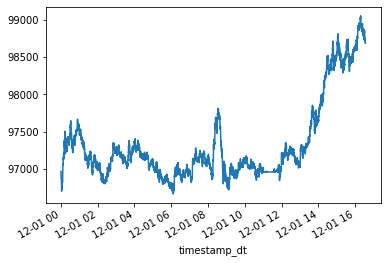

In [ ]:
equity.plot()

In [ ]:
ls = list(equity)
profit = ls[-1] - ls[0]
print(f"Profit : {np.round(profit,2)}")
 

Profit : 1717.46


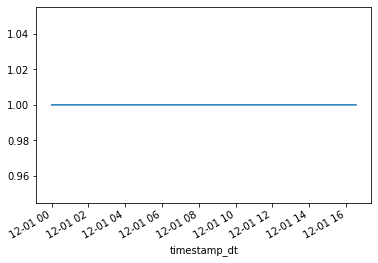

In [ ]:
base_qty.plot()

In [ ]:
# while True:
#   param_distribution = { 'A': stats.uniform(0,1), 'B': stats.uniform(0, 1), 'half_spread': stats.uniform(0, 0.001), 'order_mul' : stats.uniform(0,1), 'mp_shift':np.arange(19,25) }
#   base_qty = 1
#   quote_equity = 40000
#   order_qty_base = 0.05
#   max_pos = 250000
#   fee_pct = 0.1
#   search = RandomizedSearchCV(Backtest(base_qty,quote_equity,order_qty_base, fee_pct, max_pos, tick_size = ts),
#                               cv=[(np.arange(len(df_train)), np.arange(len(df_train)))],
#                               param_distributions=param_distribution,
#                               verbose=1,
#                               n_iter=100,
#                               n_jobs=8)

#   search.fit(df_train.values)
#   df_ = df_train
#   # df_ = df_val
#   equity_history, quote_equity_history, base_qty = search.best_estimator_.predict(df_.values)
#   quote_equity = pd.Series(quote_equity_history, index=df_.index)
#   equity = pd.Series(equity_history, index=df_.index)
#   base_qty = pd.Series(base_qty, index=df_.index)
#   ls = list(equity)
#   profit = ls[-1] - ls[0]
#   if(profit >= 900):
#     break